### Totally Wired BBQ

Here we will use the [Fireboard BBQ Thermometer](https://www.fireboard.com/shop/fireboard-fbx11-thermometer/) to monitor the progress of some beef short ribs smoking on the Weber Smoky Mountain.


In [1]:
import numpy,pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn
from datetime import date


%matplotlib inline

import requests
import json
import pandas

# function get grab session data

def get_session():
    # load auth data

    auth = json.loads(open('auth.json').readlines()[0])

    # first get session data

    response = requests.get('https://fireboard.io/api/v1/sessions.json',
                            auth=(auth['username'], auth['password']))
    # this assumes that the first session is the newest - seems correct
    session_info = response.json()[0]

    # grab session chart

    response = requests.get('https://fireboard.io/api/v1/sessions/%d/chart.json'%session_info['id'],
                            auth=(auth['username'], auth['password']))
    session_data = response.json()
    
    # print channels
    print('Detected %d channels'%len(session_data))
    for i,s in enumerate(session_data):
        print("channel %d: %s"%(i,s['label']))
    # this assumes that air temp is probe 1 and the rest are meat temps
    offset=8*3600
    session_df = pandas.DataFrame({'Air (%s)'%session_data[0]['label'].replace('Channel','Probe'):session_data[0]['y']},
                   # need to correct date stamp to match pacific time
                    index=pandas.to_datetime([i - offset for i in session_data[0]['x']],
                                                            unit='s')).tz_localize(tz='US/Pacific')

    for i in range(1,len(session_data)):
        session_df['Meat (%s)'%session_data[i]['label'].replace('Channel','Probe')]=session_data[i]['y']
 
    return(session_df)



Detected 3 channels
channel 0: Channel 1
channel 1: Channel 2
channel 2: Channel 3


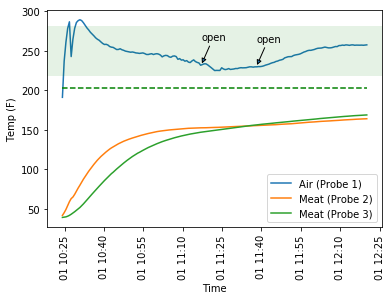

In [12]:
s = get_session()
open_vents=['11:17','11:38']

today = str(date.today())

opentimes = [pandas.to_datetime('%s %s'%(today,i), dayfirst=True).tz_localize(tz='US/Pacific') for i in open_vents]



plt.plot(s)
plt.legend(s.columns)
plt.xlabel('Time')
_=plt.ylabel("Temp (F)")

# draw range for air temp
plt.plot([s.index.min(),s.index.max()],[250,250],linewidth=50,
         alpha=0.1,color='green')
plt.plot([s.index.min(),s.index.max()],[203,203],'--',color='g')
ax=plt.gca()
props = {"rotation" : 90}
_=plt.setp(ax.get_xticklabels(), **props)


for o in opentimes:
    # find closest time stamp
    stamp = s.index.get_loc(o,method='nearest')
    ax.annotate('open', (mdates.date2num(o), 
                         s.iloc[stamp]['Air (Probe 1)']), 
            xytext=(0, 25), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

